# PDE megoldó FiPy csomaggal


A következő package-ek szükségesek:
- future
- fipy
- numpy
- matplotlib
- scipy

A megoldandó differenciálegyenlet általános alakja:

$$ \frac{\partial f(r,t)}{\partial t}=D\frac{\partial^2 f(r,t)}{\partial r^2}-K\frac{\partial f(r,t)}{\partial r}+S(r,t) $$

### Importálások és saját függvények

In [15]:
import fipy as fp
from fipy.tools import numerix  # FiPy-al használatos, gyakorlatilag numpy
import copy

#Dirac delta függvény numerikus implementálása
def delta_func(x, epsilon):
    return ((x < epsilon) & (x > -epsilon)) * \
        (1 + numerix.cos(numerix.pi * x / epsilon)) / 2 / epsilon

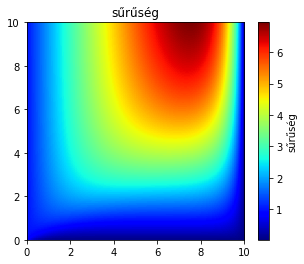

In [16]:
R = 10.  ## teljes hossz, amire lefut a program
nr = 100  ## ennyi részre lesz felosztva
dr = R / nr
mesh = fp.Grid1D(dx=dr, nx=nr)  ## új mesh nr számú dr széles lépésközzel

## idő bevezetése
duration = 10.
nt = 100
dt = duration / nt

## 2D mesh és CellVariable
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

## "megoldási változó" - sűrűségfv
n = fp.CellVariable(mesh=mesh, name="sűrűség")

# Kezdeti feltétel példák:
## n.value = 0.
## n.setValue(1., where=(x > L/2. - L/10.) & (x < L/2. + L/10.))

## diffúziós-, konvekciós- és forrásegyütthatók (D, K, S)
diffCoeff = 1.
convCoeff = [1.,]
sourceCoeff = 1.

## határfeltételek
valueLeft = 1.
gradLeft = (0.,)
valueRight = 0.
n.constrain(valueLeft, mesh.facesLeft)
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)
n.constrain(valueRight, mesh.facesRight)

## az egyenlet alakja FiPy-ban az együtthatókkal
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff)
      + sourceCoeff)

## minden időlépésben betültök egy új adatsort a 2D CellVarible egy adott szakaszába
for tcut in range(nt):
    eq.solve(var=n, dt=dt)
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)

# ELlenőrzés megjelenítéssel (még nincs Dirac-delta)
viewer = fp.Viewer(vars=cellvar2D)

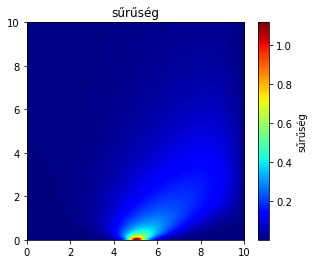

In [17]:
# Dirac delta a kezdeti feltételben, diffúzió és konvekció
# Bal oldalt 0. Neumann határfeltétel, jobb oldalt 0. Dirichlet határfeltétel
# Sugár felénél Dirac-delta kezdeti feltétel
## TEMPLATE ##

R = 10.  ## teljes sugár
nr = 100  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 10.  ## teljes szimulációs időtartam
nt = 100  ## időosztások száma
dt = duration / nt  ## időlépés

## 2D mesh és CellVariable az idő- és térfüggő eredmények tárolásához
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén
diracLoc = R / 2.  ## Dirac-delta helyzete
diracCoeff = 1.  ## Dirac-delta együtthatója (nagysága)
diffCoeff = 1.  ## diffúziós együttható
convCoeff = [1.,]  ## konvekciós együttható
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
n.setValue(diracCoeff * delta_func(mesh.x - diracLoc, 4 * dr))  ## Dirac-delta kezdeti feltétel

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Tér- és időfüggő adatbetöltés a 2D változóba
for tcut in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)
viewer = fp.Viewer(vars=cellvar2D)  ##ábrázolás